## Shallow embeddings: ejemplo con Node2Vec

### Configuración general

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')
import numpy as np
import networkx as nx
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
def plot_graph(g, comms, ax=None, pos=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(12,12))
        
    colors = np.zeros(g.number_of_nodes(), dtype='int')
    for comm, node in enumerate(comms):
        colors[node] = comm
    if pos is None:
        pos = nx.spring_layout(g, seed=22)
    nx.draw(
        g, with_labels=True, pos=pos, node_color=colors, cmap='Set2', 
        ax=ax
    )
    return ax

#### Construimos el grafo

In [4]:
g = nx.karate_club_graph()
n = g.number_of_nodes()
m = g.number_of_edges()
print(f'Cantidad de nodos: {n}')
print(f'Cantidad de links: {m}')

Cantidad de nodos: 34
Cantidad de links: 78


In [5]:
membership = np.array([g.nodes[v]['club'] for v in g])
set(membership)

{'Mr. Hi', 'Officer'}

In [6]:
original_comms = [
    np.array(g.nodes())[membership=='Mr. Hi'].tolist(),
    np.array(g.nodes())[membership=='Officer'].tolist()
]
original_comms

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
 [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]

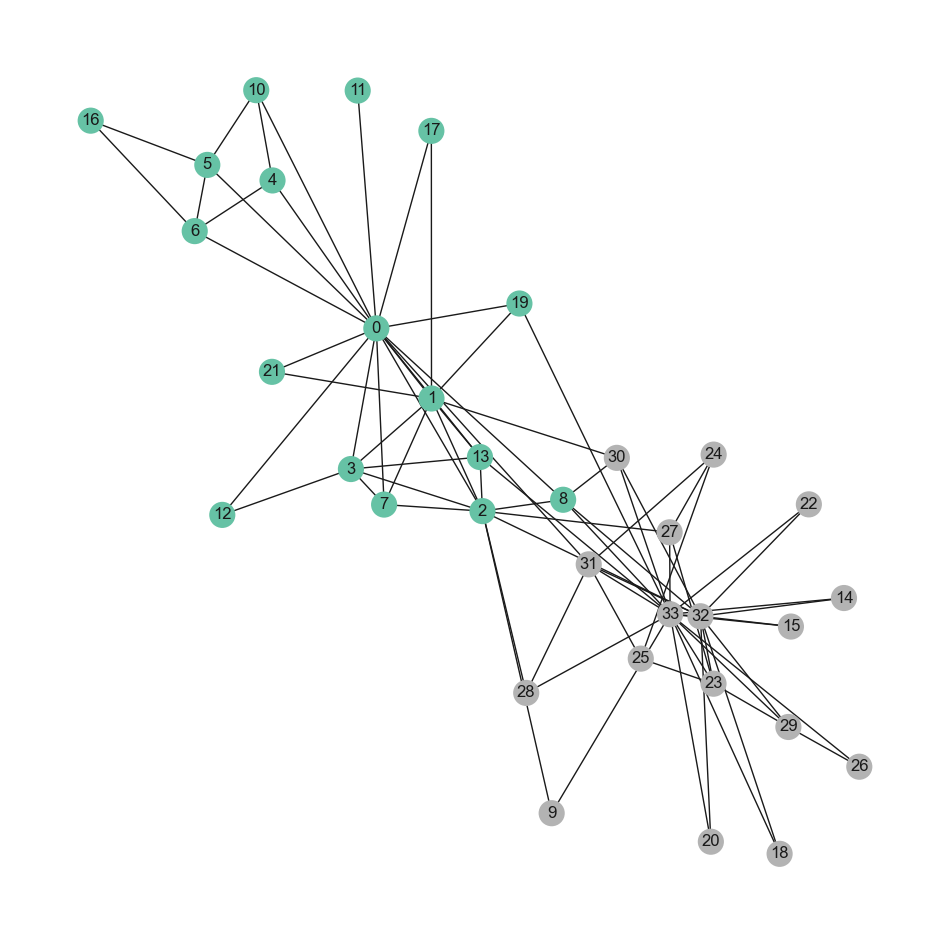

In [7]:
plot_graph(g, original_comms);

### Node2Vec

Construimos nuestro modelo `Node2Vec`.

Entrenar Node2Vec consta de dos etapas. 

**Primera etapa:** realizamos las caminatas aleatorias sobre el grafo para obtener nuestras secuencias de nodos.

**Segunda etapa:** interpretamos cada nodo como una palabra, y transformamos cada secuencia de palabras en un texto. Con este texto, entrenamos un modelo word2vec

In [24]:
## Primera etapa
dim = 50
node2vec = Node2Vec(g, dimensions=dim, walk_length=5, num_walks=100, p=1, q=1, seed=22)
type(node2vec)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 381.62it/s]


node2vec.node2vec.Node2Vec

In [25]:
## Segunda etapa
model = node2vec.fit(window=4)
type(model)

gensim.models.word2vec.Word2Vec

Al ajustar el modelo `Node2Vec`, obtenemos una instancia del modelo [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html) de la librería `gensim`.

In [26]:
embedding = np.array([model.wv[str(idx)] for idx in g.nodes()])
embedding.shape

(34, 50)

In [27]:
embedding[0]

array([-2.14339539e-01,  2.02594344e-02, -9.65451822e-03, -4.34802845e-02,
       -4.39233929e-02, -9.56624374e-02,  1.64327517e-01,  1.54058546e-01,
       -2.88766533e-01, -2.44088564e-02,  1.34801134e-01, -2.19008058e-01,
        1.23150356e-01, -7.26828277e-02, -1.96998101e-02,  1.44064799e-01,
        2.41410151e-01,  4.60492074e-01, -3.42410713e-01, -3.23999137e-01,
        4.71143760e-02,  2.02245727e-01,  4.39670771e-01,  6.01334423e-02,
        9.55801681e-02,  1.61204532e-01,  7.23855793e-02,  1.97412685e-01,
       -1.88973516e-01, -2.13776797e-01,  3.70839000e-04, -2.43302792e-01,
        1.19547099e-01, -7.65511692e-02, -1.57013938e-01, -9.77091715e-02,
        3.18073720e-01, -1.41192619e-02, -2.23313067e-02,  2.76901834e-02,
        1.26654893e-01,  2.21593212e-02, -1.94005728e-01,  5.22265285e-02,
        4.42948073e-01,  1.38238549e-01,  2.12874562e-02, -1.57948330e-01,
        5.83015718e-02,  7.51093775e-02], dtype=float32)

In [28]:
model.wv.most_similar('16')

[('5', 0.9936123490333557),
 ('6', 0.9927766919136047),
 ('10', 0.9911518692970276),
 ('4', 0.9900704622268677),
 ('0', 0.9543653726577759),
 ('11', 0.9367244839668274),
 ('17', 0.930203378200531),
 ('21', 0.927383303642273),
 ('12', 0.919451892375946),
 ('19', 0.9148541688919067)]

#### **Visualización del embedding**

Aplicamos dos algoritmos de reducción de dimensionalidad para llevar el embedding a dos dimensiones

In [29]:
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

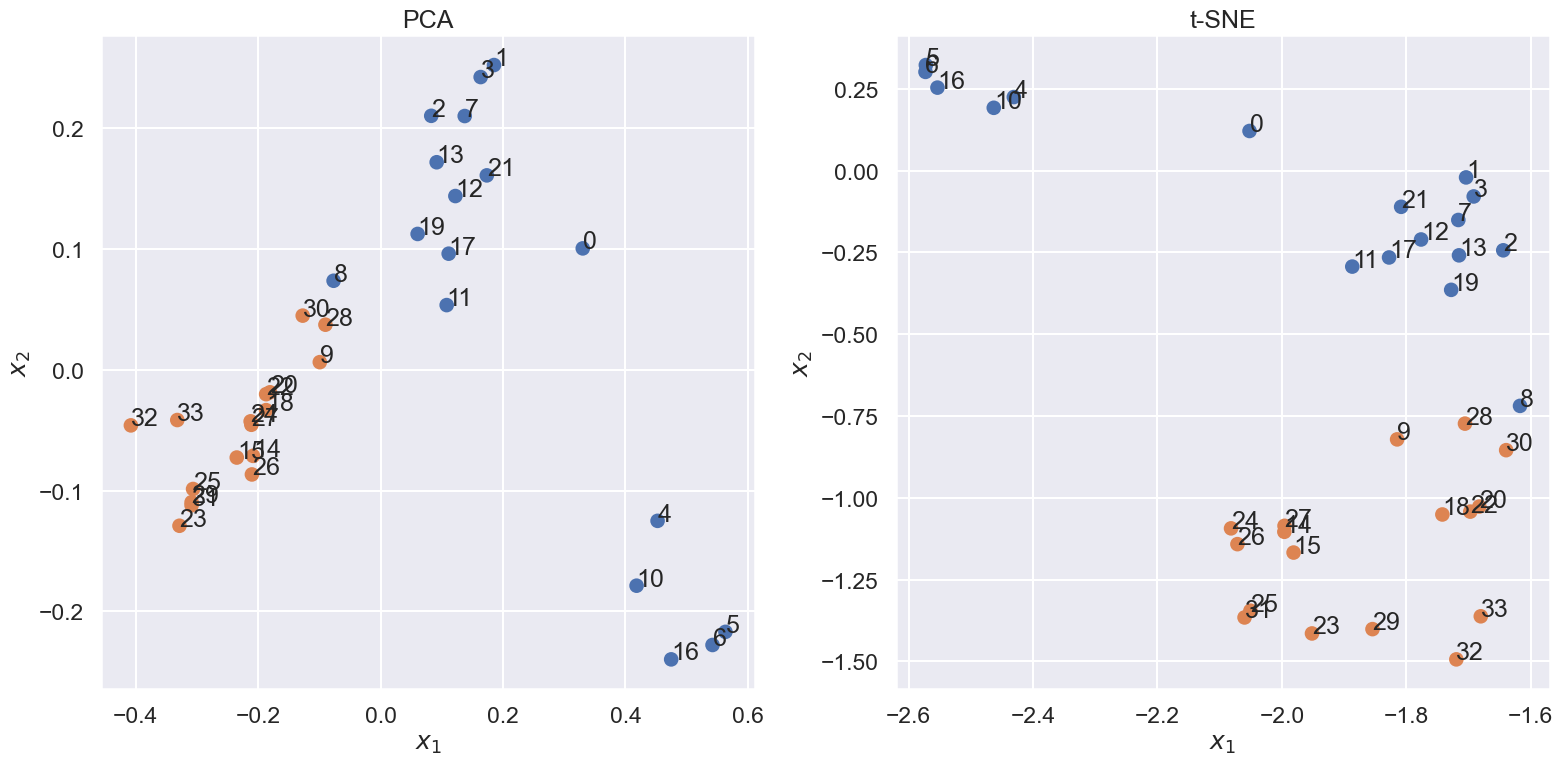

In [30]:
def add_labels(g, pos, ax):
    labels = [v for v in g.nodes()]
    for i in range(g.number_of_nodes()):
        x, y = pos[i]
        label = labels[i]
        ax.text(x, y, label)

color = ['C0' if elem == 'Mr. Hi' else 'C1' for elem in membership]
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
ax.scatter(pca[:,0], pca[:,1], c=color)
add_labels(g, pca, ax)
ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
ax.scatter(tsne[:,0], tsne[:,1], c=color)
add_labels(g, tsne, ax)
plt.tight_layout()
plt.show()

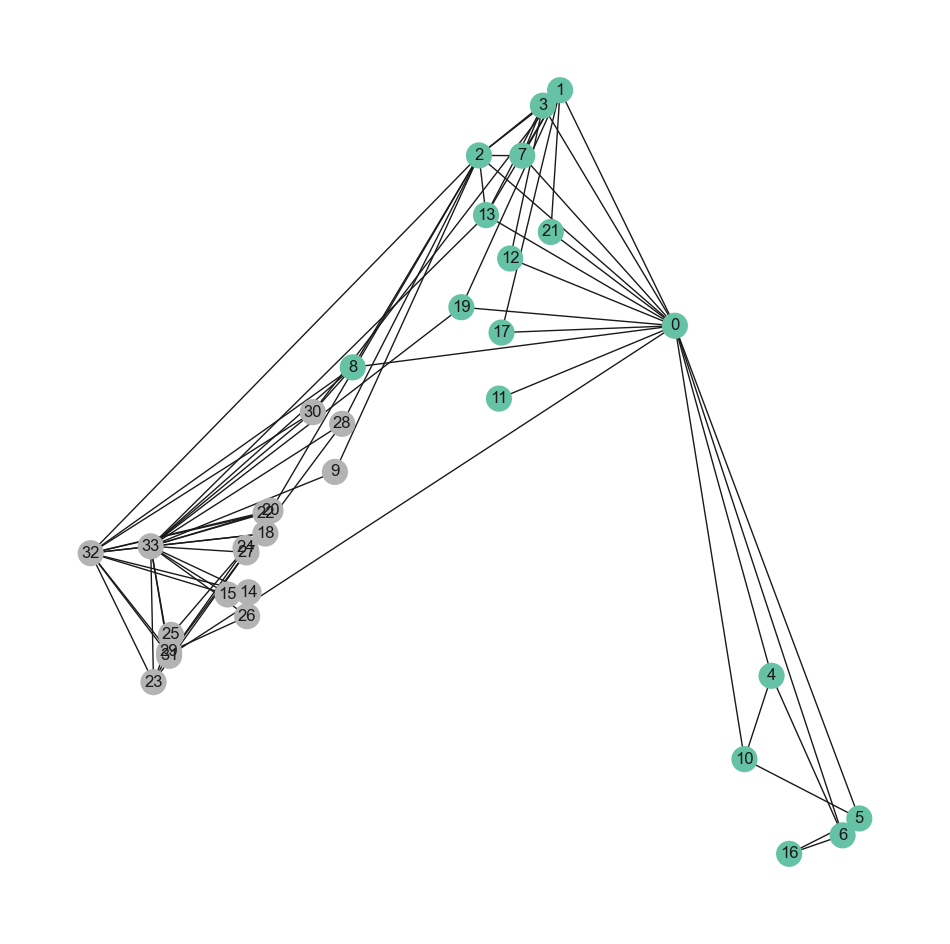

In [31]:
plot_graph(g, original_comms, pos=pca);

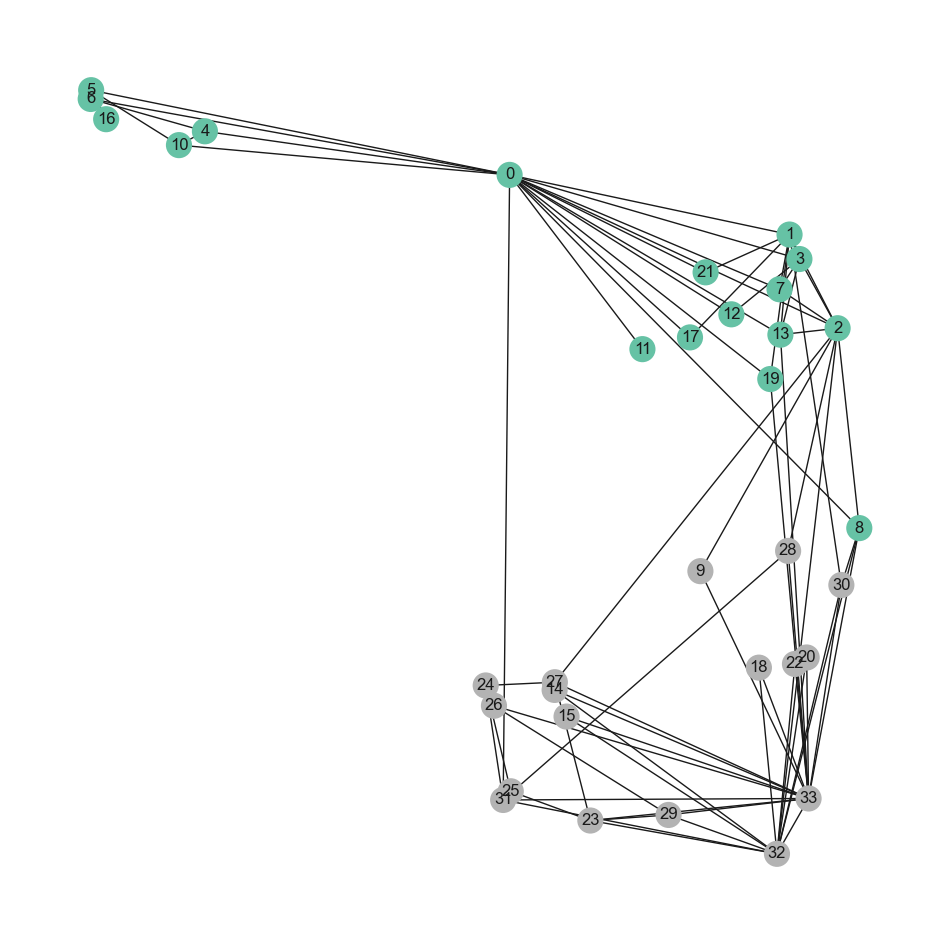

In [32]:
plot_graph(g, original_comms, pos=tsne);

### Clusterización utilizando KMeans

Utilizamos el algoritmo `KMeans` para identificar las dos comunidades a partir del embedding

In [40]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
membership = model.fit_predict(embedding)
np.where(membership)[0]
comms = [np.where(membership)[0], np.where(1-membership)[0]]

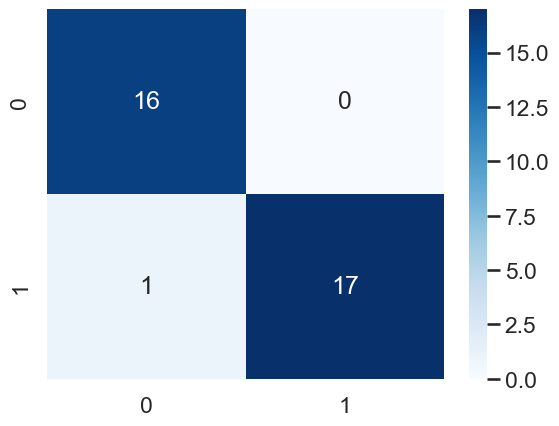

In [41]:
def create_contingency_table(comms1, comms2):
    """
    Compute contingency table between partition comms1 and
    partition comms2.

    The contingency table is defined by

    n_{kk'} = |C_k \cap C'_{k'}|.
    """
    table = np.zeros((len(comms1), len(comms2)))
    for i, c1 in enumerate(comms1):
        for j, c2 in enumerate(comms2):
            table[i,j] = len(set(c1).intersection(c2))
    return table

table = create_contingency_table(comms, original_comms)
sns.heatmap(table, annot=True, cmap='Blues');